<a href="https://colab.research.google.com/github/malekzitouni/Automatic-detection-of-fake-product-reviews/blob/main/Examen_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Automatic detection of fake product reviews**




# 1. Prétraitement des données


In [16]:
import pandas as pd
path= "/content/fake reviews dataset.csv"
df = pd.read_csv(path)
print(df.head())

             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  


## **Nettoyage du texte**

In [5]:
import re
import spacy
from nltk.corpus import stopwords

# Télécharger les stopwords et vérifier les colonnes
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Correction du nom de colonne (text_ au lieu de text)
assert 'text_' in df.columns, "La colonne 'text_' est manquante."

# Initialiser spaCy pour la lemmatisation
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)          # Supprimer la ponctuation
    text = text.lower()                           # Conversion en minuscules
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Stopwords
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.lemma_ != '-PRON-'])  # Lemmatisation (ignore les pronoms)
    return text

# Appliquer le nettoyage sur la colonne text_
df['cleaned_text'] = df['text_'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#**Encodage des labels (Correction des valeurs)**

In [19]:
print(df['label'].value_counts()['OR'])

20216


In [20]:
print(df['label'].value_counts()['CG'])

20216


In [21]:
print(df['label'].value_counts())

label
CG    20216
OR    20216
Name: count, dtype: int64


In [22]:
# Vérifier les valeurs uniques
print("Valeurs avant encodage :\n", df['label'].value_counts())

# Mapper CG=0 (fake), OR=1 (real)
label_mapping = {'CG': 0, 'OR': 1}
df['label'] = df['label'].map(label_mapping)

# Vérification
print("\nValeurs après encodage :\n", df['label'].value_counts())

Valeurs avant encodage :
 label
CG    20216
OR    20216
Name: count, dtype: int64

Valeurs après encodage :
 label
0    20216
1    20216
Name: count, dtype: int64


In [23]:
print(df.label)

0        0
1        0
2        0
3        0
4        0
        ..
40427    1
40428    0
40429    1
40430    0
40431    1
Name: label, Length: 40432, dtype: int64


# **Analyse statistique initiale**

In [32]:
# Longueur des critiques
df['text_length'] = df['text_'].apply(len)
# Distribution des classes
class_distribution = df['label'].value_counts(normalize=True)
print(class_distribution)

# Suppression des doublons
df = df.drop_duplicates(subset='text_')

label
1    0.500223
0    0.499777
Name: proportion, dtype: float64


In [33]:
print(df)

                           category  rating  label  \
0                Home_and_Kitchen_5     5.0      0   
1                Home_and_Kitchen_5     5.0      0   
2                Home_and_Kitchen_5     5.0      0   
3                Home_and_Kitchen_5     1.0      0   
4                Home_and_Kitchen_5     5.0      0   
...                             ...     ...    ...   
40427  Clothing_Shoes_and_Jewelry_5     4.0      1   
40428  Clothing_Shoes_and_Jewelry_5     5.0      0   
40429  Clothing_Shoes_and_Jewelry_5     2.0      1   
40430  Clothing_Shoes_and_Jewelry_5     1.0      0   
40431  Clothing_Shoes_and_Jewelry_5     5.0      1   

                                                   text_  text_length  
0      Love this!  Well made, sturdy, and very comfor...           75  
1      love it, a great upgrade from the original.  I...           80  
2      This pillow saved my back. I love the look and...           67  
3      Missing information on how to use it, but it i...       

#2. Analyse exploratoire (EDA)


# **Distribution des classes**

<Axes: xlabel='label', ylabel='count'>

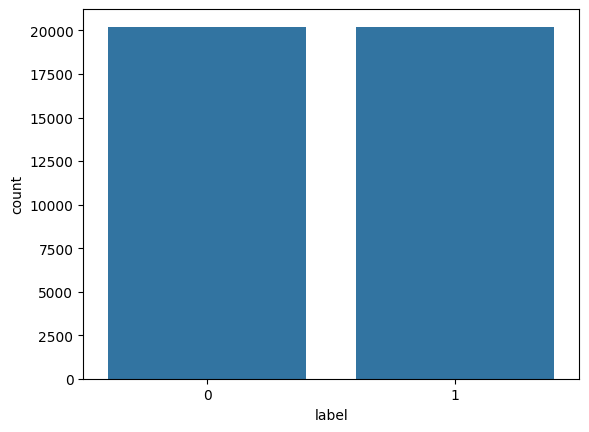

In [34]:
import seaborn as sns
sns.countplot(x='label', data=df)

# **Longueur des critiques par classe (histogramme)**

<Axes: xlabel='text_length', ylabel='Count'>

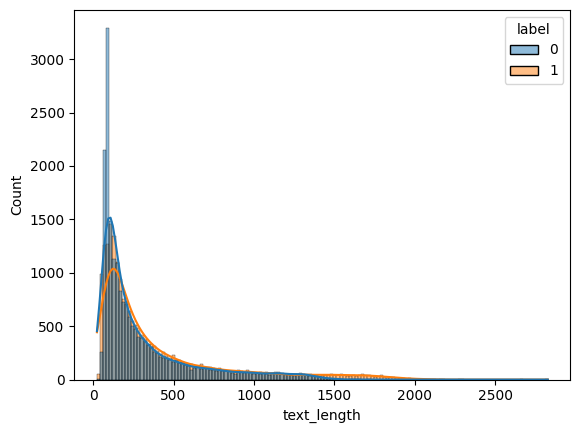

In [35]:
sns.histplot(data=df, x='text_length', hue='label', kde=True)

# **Visualisation des mots les plus fréquents (WordCloud par classe)**

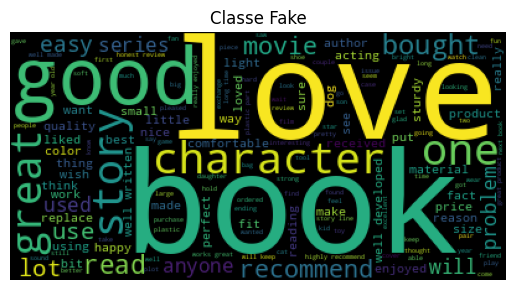

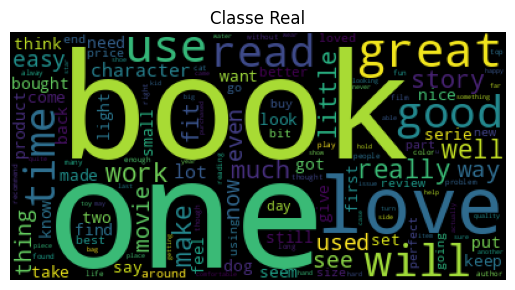

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
for label in [0, 1]:
    text = ' '.join(df[df['label'] == label]['text_'])
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.title(f"Classe {'Fake' if label == 0 else 'Real'}")
    plt.axis('off')
    plt.show()

# **Présenter au moins une autre visualisation pertinente (ex : heatmap, bigrammes fréquents)**

<Axes: >

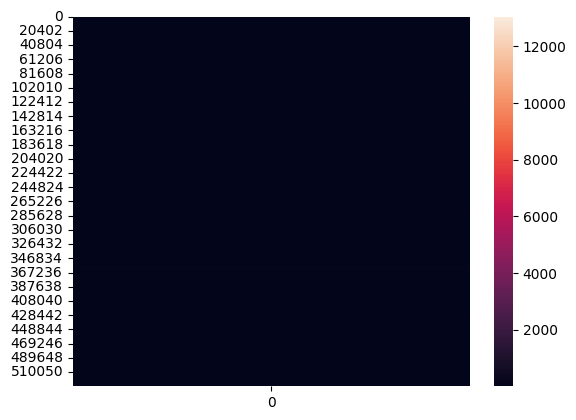

In [40]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2))
bigrams = vectorizer.fit_transform(df['text_'])
sns.heatmap(pd.DataFrame(bigrams.sum(axis=0)).T, annot=False)

# 3. Vectorisation du texte

# **Appliquer une vectorisation TF-IDF sur la colonne du Text**

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text_'])
y = df['label']

# **Comparer les dimensions, vocabulaire et effets sur la mémoire**

In [42]:
# Dimensions de la matrice TF-IDF
print("Dimensions de la matrice TF-IDF (n_échantillons, n_features) :", X.shape)

# Taille du vocabulaire
print("Taille du vocabulaire (nombre de termes uniques) :", len(tfidf.vocabulary_))

# Type de données et estimation de la mémoire utilisée (pour les matrices creuses)
print("Type de données de la matrice TF-IDF :", X.dtype)
print("Mémoire estimée utilisée par la matrice TF-IDF (en bytes) :", X.data.nbytes)

Dimensions de la matrice TF-IDF (n_échantillons, n_features) : (40412, 5000)
Taille du vocabulaire (nombre de termes uniques) : 5000
Type de données de la matrice TF-IDF : float64
Mémoire estimée utilisée par la matrice TF-IDF (en bytes) : 12576536


#4. Modélisation


# **Régression logistique (baseline)**

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

# **MLP**

In [44]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,))
mlp.fit(X_train, y_train)

MLPClassifier()

# 5. Évaluation des performances

# **Affichage des scores : accuracy, précision, rappel, F1-score, AUC**

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for model in [lr, mlp]:
    y_pred = model.predict(X_test)
    print(f"{model.__class__.__name__}:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")

LogisticRegression:
Accuracy: 0.90
F1-score: 0.90
MLPClassifier:
Accuracy: 0.89
F1-score: 0.89


# **Courbe ROC pour au moins deux modèles**

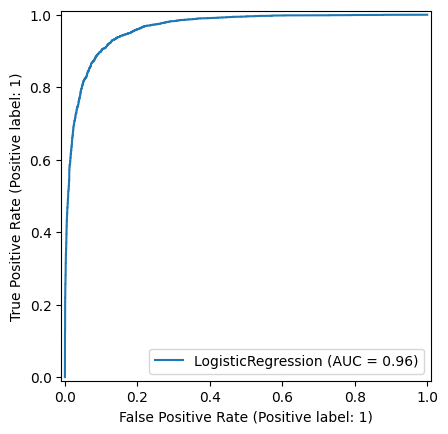

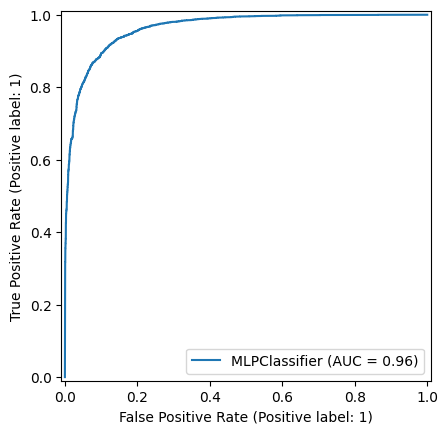

In [46]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(lr, X_test, y_test)
RocCurveDisplay.from_estimator(mlp, X_test, y_test)

# **Matrice de confusion et analyse qualitative des erreurs**

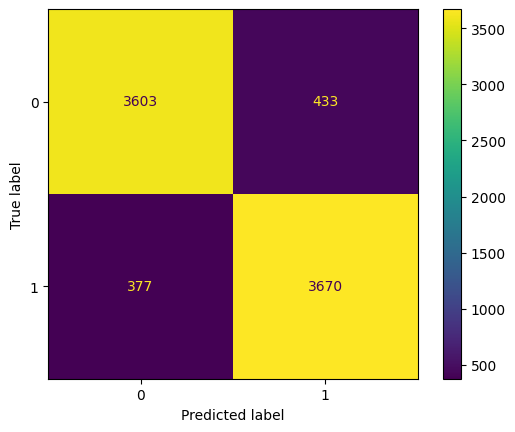

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

# 6. Interprétation des résultats

In [49]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cc60633e7e3082e42f7e145a27ac79db1f2f9e3b0d19ca943968d01a42ab5400
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [52]:
import lime.lime_text as lime
from lime import lime_text
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Create a wrapper function to vectorize the text before prediction
def predict_proba_wrapper(text_list):
    # Apply the same TF-IDF vectorizer used during training
    vectorized_text = tfidf.transform(text_list)
    # Return the prediction probabilities from the trained model
    return lr.predict_proba(vectorized_text)

explainer = lime.LimeTextExplainer()

# Exemple de critique
text_sample = df.iloc[0]['text_']
# Pass the wrapper function to explain_instance
exp = explainer.explain_instance(text_sample, predict_proba_wrapper)
exp.show_in_notebook()